# House affordability

In this footnote we compile data about housing affordability in the UK.

We will use [House Price Index](https://www.gov.uk/government/publications/about-the-uk-house-price-index/about-the-uk-house-price-index#monthly-revision) data based on residential housing transactions from the Land Registry. We can normalise this data to capture affordability using median annual salaries from ASHE that we will be collecting elsewhere.

Our strategy is to: 

* Collect the data [Here](https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-august-2019)
* Process it into the geographies we are interested in (if possible)
* Create indicators.

## Preamble

In [32]:
%run ../notebook_preamble.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def make_dirs(name,dirs = ['raw','processed']):
    '''
    Utility that creates directories to save the data
    
    '''
    
    for d in dirs:
        if name not in os.listdir(f'../../data/{d}'):
            os.mkdir(f'../../data/{d}/{name}')
            
def flat_freq(a_list):
    '''
    Return value counts for categories in a nested list
    
    '''
    return(pd.Series([x for el in a_list for x in el]).value_counts())

        

def flatten_list(a_list):
    
    return([x for el in a_list for x in el])

        

In [34]:
def save_data(df,name,path,today=today_str):
    '''
    Utility to save processed data quicker
    
    Arguments:
        df (df) is the dataframe we want to save
        name (str) is the name of the file
        path (str) is the path where we want to save the file
        today (str) is the day when the data is saved
    
    '''
    
    df.to_csv(f'{path}/{today_str}_{name}.csv')
    

In [35]:
#dirs

if 'housing' not in os.listdir('../../data/raw'):
    os.makedirs('../../data/raw/housing')

if 'housing' not in os.listdir('../../data/interim/'):
    os.makedirs('../../data/processed/housing')

## 1. Collect data

We collect the data from the land registry. The [data dictionary](https://www.gov.uk/government/publications/about-the-uk-house-price-index/about-the-uk-house-price-index#data-tables) can be found here.

In [36]:
housing_url = 'http://publicdata.landregistry.gov.uk/market-trend-data/house-price-index-data/UK-HPI-full-file-2019-08.csv?utm_medium=GOV.UK&utm_source=datadownload&utm_campaign=full_fil&utm_term=9.30_16_10_19'

hous = pd.read_csv(housing_url)

In [37]:
hous.head()

,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
0,01/01/2004,Aberdeenshire,S12000034,81693.66964,40.864214,NaN,NaN,NaN,NaN,388.0,...,88436.13953,40.267250,NaN,NaN,103.0,81043.95084,40.883367,NaN,NaN,285.0
1,01/02/2004,Aberdeenshire,S12000034,81678.76231,40.856757,NaN,-0.018248,NaN,NaN,326.0,...,88606.44649,40.344795,0.192576,NaN,107.0,80965.29542,40.843688,-0.097053,NaN,219.0
2,01/03/2004,Aberdeenshire,S12000034,83525.09702,41.780317,NaN,2.260483,NaN,NaN,453.0,...,90296.91375,41.114508,1.907838,NaN,140.0,82903.23948,41.821302,2.393549,NaN,313.0
3,01/04/2004,Aberdeenshire,S12000034,84333.67900,42.184780,NaN,0.968071,NaN,NaN,571.0,...,90319.87844,41.124964,0.025432,NaN,180.0,84003.99161,42.376586,1.327755,NaN,391.0
4,01/05/2004,Aberdeenshire,S12000034,86379.95396,43.208353,NaN,2.426403,NaN,NaN,502.0,...,91989.17763,41.885039,1.848208,NaN,167.0,86222.73484,43.495852,2.641235,NaN,335.0


We have monthly data by LAD

## 2. Process data

In [38]:
hous.shape

(128961, 54)

In [39]:
#Create a year variable to assess that coverage
hous['year'] = [int(x.split('/')[-1]) for x in hous['Date']]

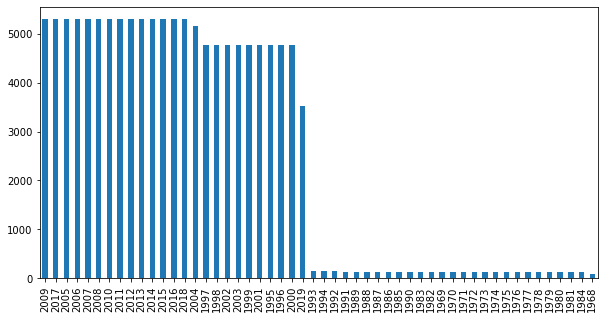

In [40]:
hous['year'].value_counts().plot.bar(figsize=(10,5))

We seem to have good coverage since around the mid 2000s. Is this linked to geography?

In [41]:
#The first letter in an area code tells us if a field is in Scotland, England or Wales
hous['nation'] = [x[0] for x in hous['AreaCode']]

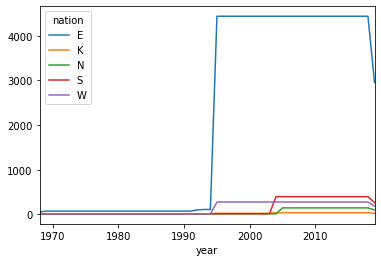

In [42]:
pd.crosstab(hous['nation'],hous['year']).T.plot()

Yes, nations are added at various points in time. We will focus on the 2010s. Note that 2019 doesn't seem to be complete. 

And what is that K?

In [43]:
hous.loc[hous['nation']=='K'].head()

,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,1m%Change,12m%Change,AveragePriceSA,SalesVolume,...,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume,year,nation
39103,01/01/1995,England and Wales,K04000001,52623.15800,26.440075,26.63423,NaN,NaN,53009.58689,49630.0,...,NaN,NaN,5533.0,51848.30164,26.422792,NaN,NaN,44097.0,1995,K
39104,01/02/1995,England and Wales,K04000001,52481.96248,26.369132,26.61621,-0.268314,NaN,52973.72072,50028.0,...,0.561758,NaN,6620.0,51641.78354,26.317547,-0.398312,NaN,43408.0,1995,K
39105,01/03/1995,England and Wales,K04000001,52545.64496,26.401129,26.56096,0.121342,NaN,52863.75897,70158.0,...,0.343269,NaN,9895.0,51686.43464,26.340302,0.086463,NaN,60263.0,1995,K
39106,01/04/1995,England and Wales,K04000001,52950.99620,26.604794,26.48197,0.771427,NaN,52706.53560,59413.0,...,-0.574579,NaN,7859.0,52195.49033,26.599726,0.984892,NaN,51554.0,1995,K
39107,01/05/1995,England and Wales,K04000001,53031.88727,26.645437,26.39754,0.152766,NaN,52538.50479,66877.0,...,0.532283,NaN,9253.0,52244.12311,26.624510,0.093174,NaN,57624.0,1995,K


We found that it is the England and Wales aggregation

In [44]:
#Subset to focus on the most recent period

hous_recent = hous.loc[hous['year']>=2010]

## Transformation

Since the data is available at the LAD (NUTS3) level we need to aggregate into LADS. We will multiply `AveragePrice` by `SalesVolume` for this.

In [45]:
hous_recent['total_sales'] = hous_recent['AveragePrice']*hous_recent['SalesVolume']

<ipython-input-45-d5ac245bef40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hous_recent['total_sales'] = hous_recent['AveragePrice']*hous_recent['SalesVolume']


In [46]:
house_year = hous_recent.groupby(['RegionName','AreaCode','year'])['total_sales'].sum()

In [47]:
house_year_wide = house_year.reset_index(drop=False).pivot_table(index=['RegionName','AreaCode'],columns='year',values='total_sales',aggfunc='sum')

In [48]:
house_year_wide.head()

,year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
RegionName,AreaCode,,,,,,,,,,
Aberdeenshire,S12000034,7.579935e+08,7.516283e+08,7.664437e+08,9.388898e+08,1.127599e+09,1.019902e+09,7.736225e+08,7.994695e+08,7.512882e+08,3.537788e+08
Adur,E07000223,1.806500e+08,2.014896e+08,2.108185e+08,2.254409e+08,2.810465e+08,2.919113e+08,3.273564e+08,3.274533e+08,3.177828e+08,1.312343e+08
Allerdale,E07000026,1.561267e+08,1.510788e+08,1.399378e+08,1.808563e+08,2.128089e+08,2.150594e+08,2.099644e+08,2.327719e+08,2.350042e+08,1.043371e+08
Amber Valley,E07000032,2.057691e+08,1.958332e+08,1.933983e+08,2.372675e+08,3.012660e+08,3.328212e+08,3.712400e+08,3.750379e+08,3.922881e+08,1.802822e+08
Angus,S12000041,2.039300e+08,1.770249e+08,1.774406e+08,2.267696e+08,2.685474e+08,2.830707e+08,2.744535e+08,2.976981e+08,2.902438e+08,1.353140e+08


In [49]:
house_year_wide[2018].sort_values(ascending=False).head(n=20)

RegionName                AreaCode 
United Kingdom            K02000001    2.438676e+11
Great Britain             K03000001    2.297140e+11
England and Wales         K04000001    2.142956e+11
England                   E92000001    2.069768e+11
South East                E12000008    4.702713e+10
London                    E12000007    4.291038e+10
East of England           E12000006    2.895415e+10
South West                E12000009    2.563394e+10
Outer London              E13000002    2.341445e+10
Inner London              E13000001    2.024504e+10
North West                E12000002    1.858699e+10
West Midlands Region      E12000005    1.687094e+10
East Midlands             E12000004    1.530781e+10
Scotland                  S92000003    1.500825e+10
Yorkshire and The Humber  E12000003    1.373356e+10
Northern Ireland          N92000001    9.882000e+09
Surrey                    E10000030    7.753751e+09
Essex                     E10000012    7.682323e+09
Wales                     W9

So the data seem to include, in fact, NUTS2 areas. Now we need to pull them out.

**We will get NUTS2 codes for 2018 and 2015 and look for them in the data**

We use the codes from [Open Geography Portal](https://geoportal.statistics.gov.uk/search?collection=Dataset&sort=name&tags=NAC_NUTS2)

In [50]:
#Here is the lookup

lad_nuts_lookup = pd.read_csv('https://opendata.arcgis.com/datasets/2a2548641a294734ba4fdb689b12d955_0.csv')

In [51]:
house_year_nuts = pd.merge(house_year.reset_index(drop=False),
                           lad_nuts_lookup[['LAD16CD','LAD16NM','NUTS318CD','NUTS318NM','NUTS218CD','NUTS218NM']],
                           left_on='AreaCode',
                           right_on='LAD16CD',how='left')

In [52]:
house_year_nuts.head()

,RegionName,AreaCode,year,total_sales,LAD16CD,LAD16NM,NUTS318CD,NUTS318NM,NUTS218CD,NUTS218NM
0,Aberdeenshire,S12000034,2010,7.579935e+08,S12000034,Aberdeenshire,UKM50,Aberdeen City and Aberdeenshire,UKM5,North Eastern Scotland
1,Aberdeenshire,S12000034,2011,7.516283e+08,S12000034,Aberdeenshire,UKM50,Aberdeen City and Aberdeenshire,UKM5,North Eastern Scotland
2,Aberdeenshire,S12000034,2012,7.664437e+08,S12000034,Aberdeenshire,UKM50,Aberdeen City and Aberdeenshire,UKM5,North Eastern Scotland
3,Aberdeenshire,S12000034,2013,9.388898e+08,S12000034,Aberdeenshire,UKM50,Aberdeen City and Aberdeenshire,UKM5,North Eastern Scotland
4,Aberdeenshire,S12000034,2014,1.127599e+09,S12000034,Aberdeenshire,UKM50,Aberdeen City and Aberdeenshire,UKM5,North Eastern Scotland


In [53]:
print(len(house_year))

print(len(house_year_nuts))

4410
4500


There are some missing locations in the merge. What are they?

In [54]:
house_year_nuts.loc[house_year_nuts['NUTS218NM'].isna()]['RegionName'].value_counts().head()

Surrey            10
East Sussex       10
Staffordshire     10
Hampshire         10
West Yorkshire    10
Name: RegionName, dtype: int64

They are the non-LAD regions in the data. We are ok to drop them

In [55]:
house_year_nuts = house_year_nuts.dropna(axis=0)

And now we calculate the NUTS2 estimates

In [56]:
house_year_nuts_2 = house_year_nuts.groupby(['NUTS218CD','NUTS218NM','year'])['total_sales'].sum()

In [57]:
house_year_nuts_2_wide = house_year_nuts_2.reset_index(drop=False).pivot_table(index=['NUTS218CD','NUTS218NM'],columns='year',values='total_sales').sort_values(
    2018,ascending=False)

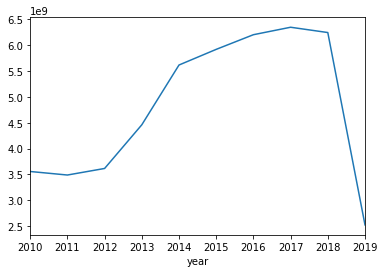

In [58]:
#Mean volume of sales per NUTS2 area /year?
house_year_nuts_2_wide.describe().loc['mean'].plot()

We note much less activity in 2019 because the House Price Index data is laggy. We will therefore remove 2019 from the analysis and save the data

In [59]:
house_final = house_year_nuts_2.reset_index(drop=False).query('year != 2019')

## 3. Save data

In [60]:
save_data(house_final,name='nuts_house_prices',path='../../data/interim/housing/')